# Swarm Modelling

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from model.modules import *

from model.bonding import *
from model.helpers import *

# Bonding Curve

$$
f(x) = C x^{r-1} + 1
$$

At a token supply of investor issuance + developer issuance, where C is a constant, r is the reserve ratio, and p is the price point after initial token issuance:

$$
\begin{aligned}
x & = inv + dev \\
p & = C (inv + dev)^{r-1} \\
C & = p / (inv + dev)^{r-1} \\
\end{aligned}
$$

$$
\int_{}^{} f(x) dx = \frac{C x^{r}}{r} = p(inv + dev)/r
$$

## Price formula using invariant reserve ratio

$$
P(x) = \frac{RB}{CS * RR}
$$

Where:
$$
\begin{aligned}
RB & \equiv \text{reserve token balance} \\
CS & \equiv \text{continuous token supply} \\
RR & \equiv \text{reserve ratio} \\
\end{aligned}
$$

and

$$
RR = \frac{RB}{CS*CP}
$$

Where:
$$
CP \equiv \text{continuous token price}
$$

## Purchase: collateral to token conversion

$$
purchase(r) = CS * ((\frac{1 + r}{RB})^{RR} - 1)
$$

Where:

$$
r \equiv \text{reserve tokens received}
$$

## Sell: token to collateral conversion

$$
sell(t) = RB * ((\frac{1+t}{CS})^{\frac{1}{RR}} - 1)
$$

Where:

$$
t \equiv \text{continuous tokens received}
$$

## Resources

https://gist.github.com/nagydani/d5c09c331224bfbffbcbe28b347ceb8e
https://gitlab.com/grassrootseconomics/cic-modeling/-/blob/master/Simulation/CIC_Network_cadCAD_model.ipynb
https://yos.io/2018/11/10/bonding-curves/

## Terminology

* BZZ: Swarm fundraising token
* Primitive function: Indefinite integral

## Constants

In [27]:
reserve_ratio = 32
n = int(math.log2(reserve_ratio))

# initially 1 BZZ = reserve_ratio DAI
assert reserve_ratio == 2**n

print('Log2 of reserve ratio: ' + str(n))

Log2 of reserve ratio: 5


## Initial token sale

In [28]:
initial_raise = 3e6
premine = initial_raise

# 6M DAI worth of tokens issued initially
initial_reserve = initial_raise + premine

# Premined developer tokens
initial_dev_supply = premine/reserve_ratio
# Initial supply in BZZ
initial_supply = initial_reserve/reserve_ratio
# Investor tokens
initial_inv_supply = initial_supply - initial_dev_supply
# Token cap. in BZZ
max_supply = initial_supply * 2

print('Initial supply: ' + str(initial_supply))

Initial supply: 187500.0


## Helper Functions

In [29]:
def nth_square(x, n):
    y = x
    for i in range(1, n):
        x = (x * x) # / initial_supply
    return x + y

## Bonding Functions

In [30]:
coeff = nth_square(initial_supply + 1, n) - nth_square(initial_supply, n)

C = 1 / nth_square(initial_supply, n)

def bonding_function(x):
    return 1 + C * math.pow(x, reserve_ratio - 1)

def original_bonding_function(x):
    return 1 + math.pow(x, reserve_ratio - 1) / math.pow(1, reserve_ratio - 1)

# Primitive function of bonding function (integral): tokens -> collateral
# where nth_square(x, 5) == x^32

def f1(x):
    return x + C * base_units * nth_square(x, n) / reserve_ratio

def f2(x):
    return x + (reserve_ratio - 1) * nth_square(x, n) / coeff                                                                   

primitive_function = f2

# Inverse integral: collateral -> tokens
def inverse_integral(x):
    C = 1
    return 1e18 * (math.pow(2, 5/32) * math.pow(x, 1/float(32))) / math.pow(C, 1/float(32))

# Price of 1 token at supply x
def spot_price(x):
    return primitive_function(x + 1) - primitive_function(x)

print('Coefficient: ' + str(coeff/1e18))

C * base_units / reserve_ratio
(reserve_ratio - 1) * base_units / coeff

Coefficient: 1.991390520619911e+62


1.33915136603186e-68

1.556701193412824e-61

In [31]:
initial_supply
inverse_integral(primitive_function(initial_supply))

187500.0

1.6843842704068713e+18

### Solidity implementation: nth_square & primitive_function

```solidity
int256 reserve_ratio = 32;
int256 decimals = 18;
int256 base_units = 10**decimals;
int256 n = 5;
int256 initial_reserve = 6e6 * base_units;
int256 initial_supply = initial_reserve / reserve_ratio;
int256 coeff = nth_square(initial_supply + base_units, n) - nth_square(initial_supply, n);

function nth_square(int256 x, int256 n) public {
    return x;
}

function primitive_function(int256 x) public {
    return x + (reserve_ratio - 1) * base_units * nth_square(x, n) / coeff;
}
```

In [32]:
primitive_function(0)
primitive_function(initial_supply)

0.0

550766.7189691936

In [34]:
# DAI available immediately
collect = initial_raise - (primitive_function(initial_supply) - primitive_function(0))
millify(collect)

collect = initial_raise - (f2(initial_supply) - f2(0))
millify(collect)

# Worst case DAI value of premine (everybody else cashes out before)
worst = primitive_function(initial_dev_supply) - primitive_function(0)
millify(worst)

worst = f2(initial_dev_supply) - f2(0)
millify(worst)

'2.449 Million'

'2.449 Million'

'93.756 Thousand'

'93.756 Thousand'

In [35]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})

Text(0.5, 1.0, 'Bonding function')

Text(0, 0.5, 'Price (Dai)')

Text(0.5, 0, 'Supply (Tokens)')

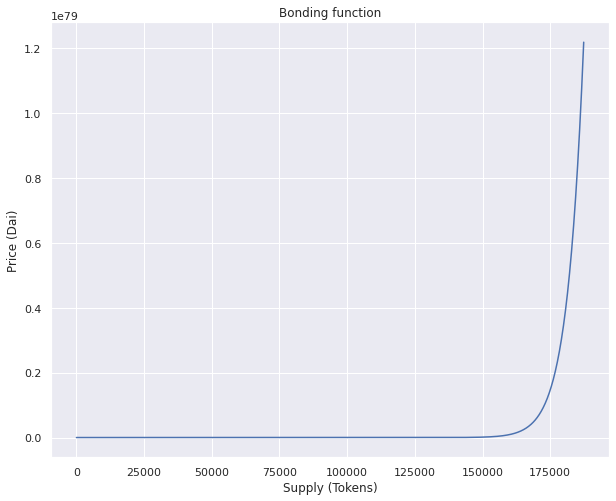

In [37]:
X = list(range(1, int(initial_supply), int((initial_supply) / 1000)))

_, = plt.plot(X, list(map(bonding_function, X)))
# _, = plt.plot(X, list(map(original_bonding_function, X)))

plt.title('Bonding function')
plt.ylabel('Price (Dai)')
plt.xlabel('Supply (Tokens)')
plt.show()

Text(0.5, 1.0, 'Primitive function')

Text(0, 0.5, 'Reserve (Dai)')

Text(0.5, 0, 'Supply (Tokens)')

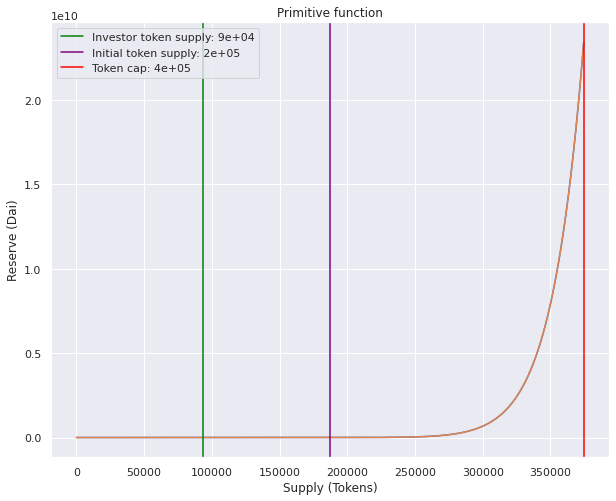

Max supply: 3.75e-13 tokens
Max reserve: $0.000


In [38]:
X = list(range(1, int(max_supply), int(max_supply / 1000)))
Y = list(map(primitive_function, list(X)))

_, = plt.plot(
    X,
    list(map(primitive_function, list(X)))
)

_, = plt.plot(
    X,
    list(map(f2, list(X)))
)

plt.title('Primitive function')
plt.ylabel('Reserve (Dai)')
plt.xlabel('Supply (Tokens)')

plt.axvline(x=initial_inv_supply, color='green', label='Investor token supply: {:5.0}'.format(initial_inv_supply))
plt.axvline(x=initial_supply, color='purple', label='Initial token supply: {:5.0}'.format(initial_supply))
plt.axvline(x=max_supply, color='red', label='Token cap: {:5.0}'.format(max_supply))

# plt.legend([curve], ['Swarm'])
plt.legend()
plt.show()

print('Max supply: ' + str(max_supply/1e18) + ' tokens')
print('Max reserve: $' + millify(primitive_function(max_supply)/1e18))

Text(0.5, 1.0, 'Primitive function')

Text(0, 0.5, 'Reserve (Dai)')

Text(0.5, 0, 'Supply (Tokens)')

Initial token price: 3.2e-17 Dai


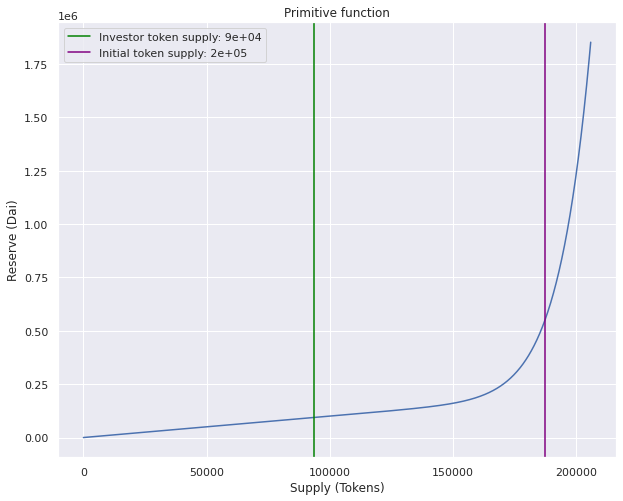

In [39]:
X = range(1, int(initial_supply + initial_supply/10), int(initial_supply / 1000))
Y = map(primitive_function, list(X))

swarm_curve, = plt.plot(list(X), list(Y))

plt.title('Primitive function')
plt.ylabel('Reserve (Dai)')
plt.xlabel('Supply (Tokens)')

plt.axvline(x=initial_inv_supply, color='green', label='Investor token supply: {:5.0}'.format(initial_inv_supply))
plt.axvline(x=initial_supply, color='purple', label='Initial token supply: {:5.0}'.format(initial_supply))

print('Initial token price: ' + str(spot_price(initial_supply)/1e18) + ' Dai')

plt.legend()
plt.show()

Text(0.5, 1.0, 'Primitive function')

Text(0, 0.5, 'Reserve (Dai)')

Text(0.5, 0, 'Supply (Tokens)')

Start token price: 1.556701193417494e+191 Dai
End token price: 1.5567011934221637e+191 Dai


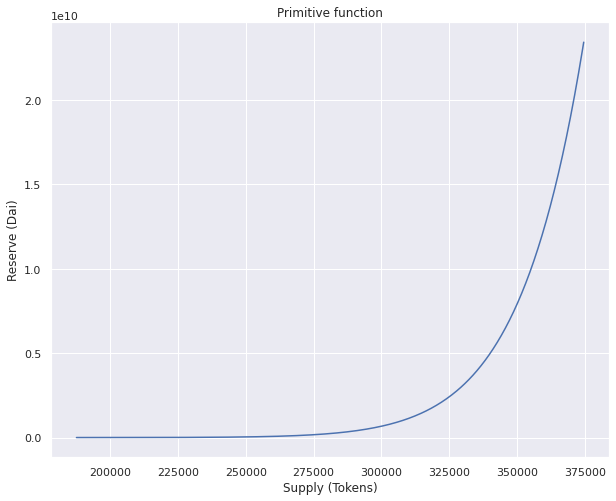

In [40]:
start_supply = initial_supply
end_supply = initial_supply*2

X = range(int(start_supply), int(end_supply), int(end_supply / 1000))
Y = map(primitive_function, list(X))

swarm_curve, = plt.plot(list(X), list(Y))

plt.title('Primitive function')
plt.ylabel('Reserve (Dai)')
plt.xlabel('Supply (Tokens)')

print('Start token price: ' + str((primitive_function(start_supply + 1e18) - primitive_function(start_supply))/1e18) + ' Dai')
print('End token price: ' + str((primitive_function(end_supply + 1e18) - primitive_function(end_supply))/1e18) + ' Dai')

plt.show()

Text(0.5, 1.0, 'Primitive function')

Text(0, 0.5, 'Reserve (Dai)')

Text(0.5, 0, 'Supply (Tokens)')

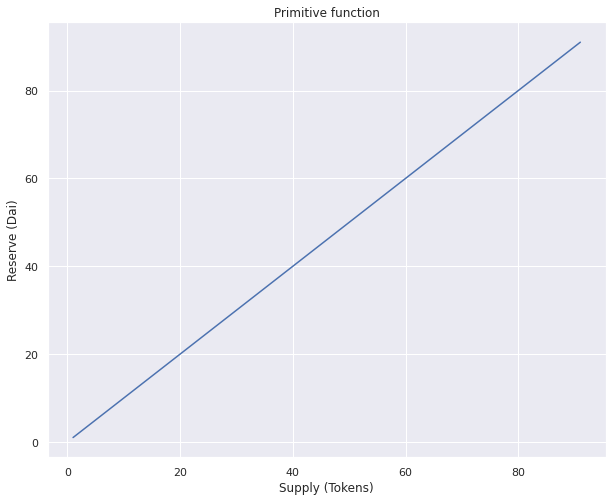

In [41]:
X = range(1, int(100), int(10))
Y = map(primitive_function, list(X))

swarm_curve, = plt.plot(list(X), list(Y))

plt.title('Primitive function')
plt.ylabel('Reserve (Dai)')
plt.xlabel('Supply (Tokens)')
plt.show()

assert primitive_function(0) == 0

In [42]:
import numpy as np

Text(0.5, 1.0, 'Reserve ratio')

Text(0.5, 0, 'Market cap.')

Text(0, 0.5, 'Reserve')

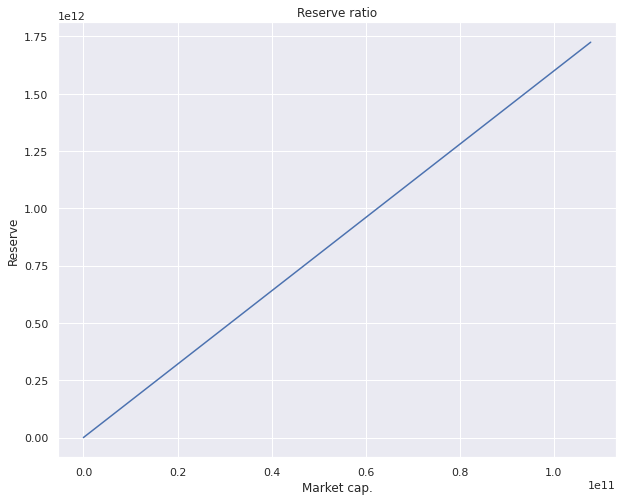

In [43]:
X = list(range(1, int(max_supply + max_supply/10), int(max_supply / 1000)))

M = list(map(lambda x: x * spot_price(x), X))
R = list(map(primitive_function, X))

plt.title('Reserve ratio')
plt.xlabel('Market cap.')
plt.ylabel('Reserve')
plt.plot(R, M)

0.09306408909552238


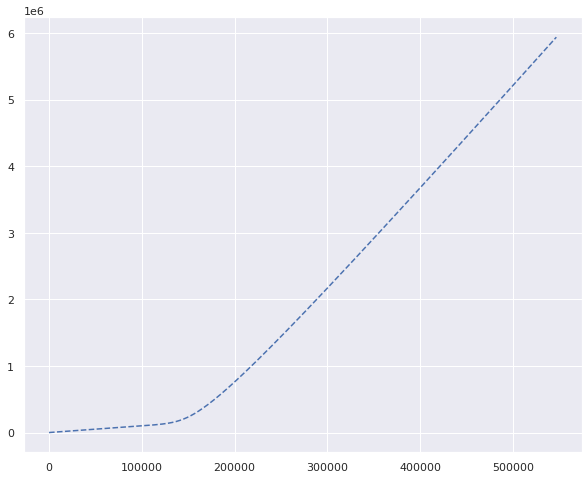

In [44]:
X = list(range(1, int(initial_supply), int(initial_supply / 1000)))

M = [x * spot_price(x) for x in X]
R = [primitive_function(x) for x in X]

slope, intercept = np.polyfit(M, R, 1)
plt.plot(R, M, '--')

print(slope)

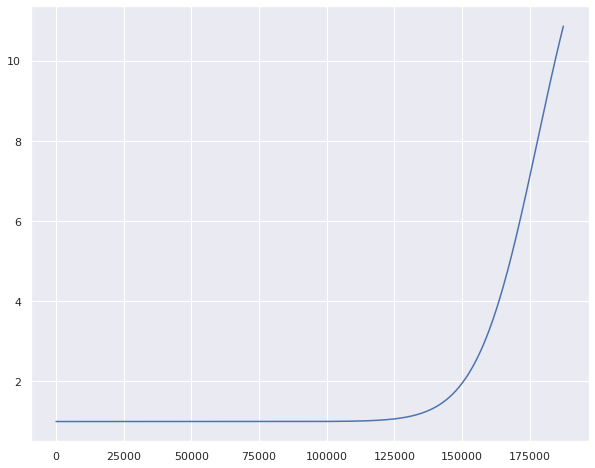

In [45]:
invRR = [(x * spot_price(x)) / primitive_function(x) for x in X]

plt.plot(X, invRR)